<font size = "5"> **Lecture 6:  [Analysis of Spectoscopy Data in STEM](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

## Distortion Matrix from Comparison of Atom Positions to Regular Latice

[<img src=https://www.coeuscreativegroup.com/wp-content/uploads/2020/04/download-button.png, width=125>](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023/raw/main/Lecture%206/1_distortion_matrix-short.ipynb) 

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/SergeiVKalinin/ML-ElectronMicroscopy-2023/blob/main/Lecture%206/1_distortion_matrix-short.ipynb)

part of Online Course

<font size = "5"> **[Machine Learning in Scanning Electron Microscopy 2023](https://github.com/SergeiVKalinin/ML-ElectronMicroscopy-2023)**</font>

<font size = "3"> **[Lecture 6](https://github.com/gduscher/ML-ElectronMicroscopy-2023/tree/main/Lecture%206)**</font>

by Gerd Duscher, and  Matthew. F. Chisholm 2023

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville

## Prerequesites

### Install pyTEMlib

In Google Colab you have to install first all the necessary additional packages. For a local installation, this has to be run only once.



We us this notebook **only** for a registered stack of images from a reference crystal.
Please use the other strain analysis notebook to analyse undistorted image stacks.


In [2]:
import sys

from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version


# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.5.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/sidpy.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/SciFiReaders.git@main -q
    !{sys.executable} -m pip install git+https://github.com/pycroscopy/pyTEMlib.git@main -q
    !{sys.executable} -m pip install simpleitk
    
# ------------------------------
print('done')

done


## First we import the usual libraries

Now we can load the necessary libraries

In [3]:
%load_ext autoreload
%autoreload 2

sys.path.insert(0, '../../pyTEMlib')

In [4]:
%matplotlib ipympl
import numpy as np
import matplotlib.pylab as plt 
import sys

if 'google.colab' in sys.modules:
    from google.colab import output
    output.enable_custom_widget_manager()
    from google.colab import drive


import pyTEMlib
from pyTEMlib import file_tools     # File input/ output library
from pyTEMlib import image_tools
from pyTEMlib import probe_tools
from pyTEMlib import atom_tools
import pyTEMlib.kinematic_scattering  as ks             # Kinematic sCattering Library
import skimage
# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)
__notebook__ = '1_distortion_matrix'
__notebook_version__ = '2023_5_20'


You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled
Qt dialogs are not available
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.5.2


## Load an atomic resolution image

We load a registered stack. If you have done some of the anlysis and you just want to work on. jump directly below  the last logging of results you did.


In [5]:
### Open file widget
fileWidget = file_tools.FileWidget()

**Next cell must be run to activate selection**

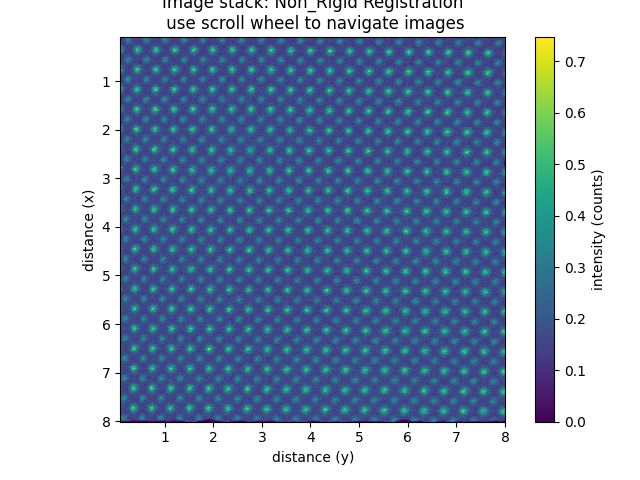

In [6]:
datasets = fileWidget.datasets

dataset = fileWidget.selected_dataset
if dataset.data_type.name != 'IMAGE_STACK':
    print('We really would need a stack of images here')
dataset.x.dimension_type  = 'spatial'    
dataset.y.dimension_type  = 'spatial'    
view = dataset.plot()

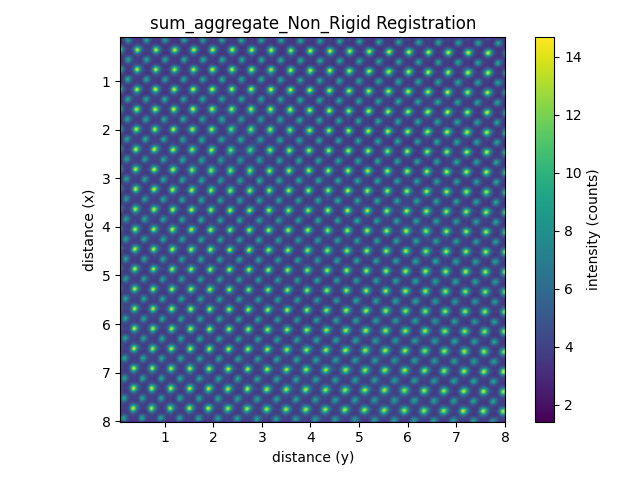

In [7]:

if dataset.data_type.name == 'IMAGE_STACK':
    image = dataset.sum(axis=0)
else:
    image = dataset
image.data_type = 'image'
view = image.plot()

## Find Atom Positions

### Lucy -Richardson Deconvolution
Lucy - Richardson Deconvolution removes noise and convolutes the intensity back into the atom (columns).

Ideally the atom_size should be as large as the atoms in the image.

A good Lucy-Richardson Deconvolution should result in an image with atoms of a radius of about 2 pixels.

The number of steps to convergence should be less than 300 for a good approximation of atom_size.

Deconvolution of  Non_Rigid Registration


  0%|          | 0/500 [00:00<?, ?it/s]

terminate
converged in 501 iterations

 Lucy-Richardson deconvolution converged in 501  iterations


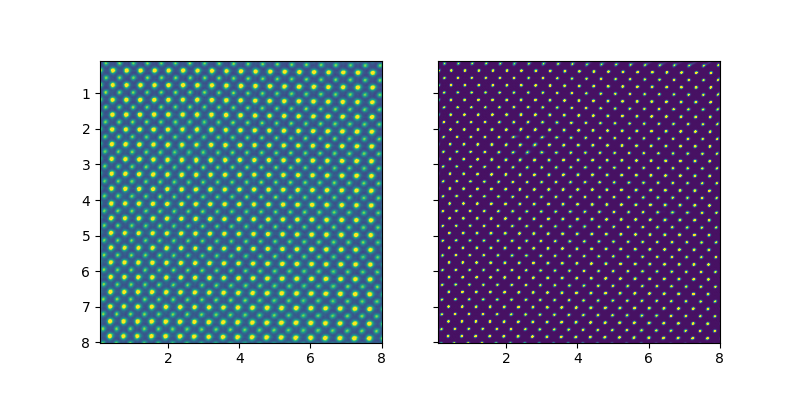

In [8]:
# ------- Input ------
atoms_size = 0.09 # in nm
# --------------------

out_tags = {}
image.metadata['experiment']= {'convergence_angle': 30, 'acceleration_voltage': 200000.}

scale_x = file_tools.get_slope(image.dim_0)
gauss_diameter = atoms_size/scale_x
gauss_probe = pyTEMlib.probe_tools.make_gauss(image.shape[0], image.shape[1], gauss_diameter)

print('Deconvolution of ', dataset.title)
LR_dataset = image_tools.decon_lr(image, gauss_probe, verbose=False)

extent = LR_dataset.get_extent([0,1])
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image[:500,:500].T, extent = extent,vmax=np.median(np.array(image))+3*np.std(np.array(image)))
ax[1].imshow(LR_dataset[:500,:500].T, extent = extent, vmax=np.median(np.array(LR_dataset))+3*np.std(np.array(LR_dataset)));

### Log Deconvolution

In [9]:
LR_dataset.metadata = {'analysis': 'Lucy_Richardson',
                        'name': 'Lucy_Richardson',
                        'notebook': __notebook__ ,
                        'notebook_version': __notebook_version__,
                        'input': dataset.title,
                        'probe_diameter': gauss_diameter,
                        'kind_of_probe': 'Gauss',
                        'probe_width': atoms_size
                        }
                          
datasets['LR_deconvolution'] = LR_dataset

### Choose Image Channel for Atom Detection

In [10]:
image_choice = file_tools.ChooseDataset(datasets)  

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'LR_deconvolut…

### Blob Detection

Please note that we are working with pixel values at this point

795


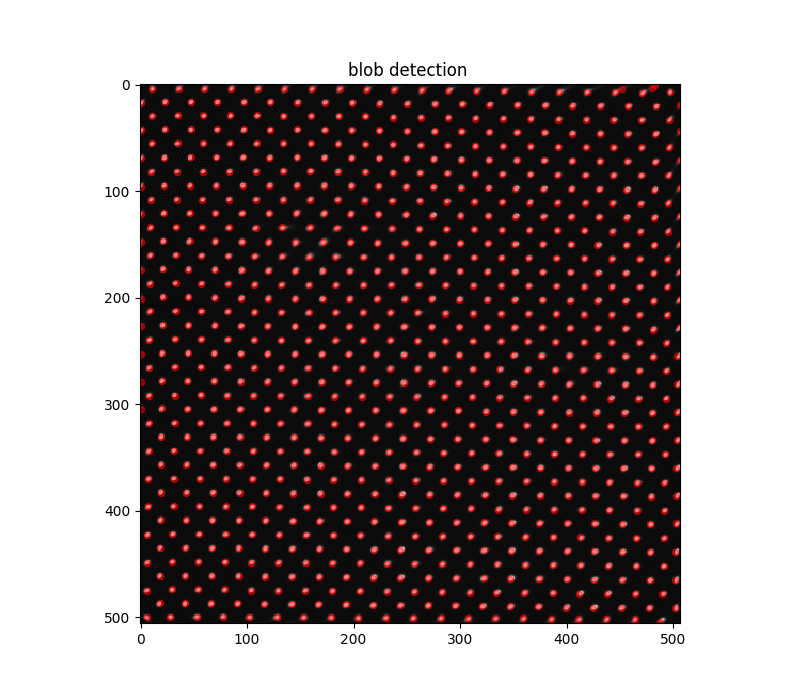

In [11]:
# ------- Input ------
threshold = 3. #usally between 0.01 and 0.9  the smaller the more atoms
atom_size = .06 #in nm  
# ----------------------

image = image_choice.dataset
#image = image_choice.dataset
scale_x = file_tools.get_slope(image.dim_1)
blobs =  skimage.feature.blob_log(image, max_sigma=atom_size/scale_x, threshold=threshold)
print(len(blobs))
fig1, ax = plt.subplots(1, 1,figsize=(8,7), sharex=True, sharey=True)
plt.title("blob detection ")

plt.imshow(image.T, interpolation='nearest',cmap='gray', vmax=np.median(np.array(image))+3*np.std(np.array(image)))
plt.scatter(blobs[:, 0], blobs[:, 1], c='r', s=20, alpha = .5);

### Log Atom Positions

In [12]:
out_tags  =  {}
out_tags['analysis']= 'Atom Pixel'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['atoms'] = blobs
out_tags['atom_size'] = atom_size #in nm gives the size of the atoms or resolution
out_tags['threshold'] =  threshold  #between 0.01 and 0.1 
out_tags['pixel_size'] = scale_x


out_tags['name'] = 'blob_finding'
out_tags['title'] = out_tags['name']
datasets[out_tags['name']] = out_tags



### Refine All Atom Positions

There will be convergence errors if the atom_radius value is too large or too small

In [14]:
image_choice = file_tools.ChooseDataset(datasets)  

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'LR_deconvolut…

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'LR_deconvolut…

sidpy.Dataset of type IMAGE with:
 dask.array<sub, shape=(507, 506), dtype=float64, chunksize=(507, 506), chunktype=numpy.ndarray>
 data contains: intensity (counts)
 and Dimensions: 
y:  distance (y) of size (507,)
x:  distance (x) of size (506,)
 with metadata: ['analysis', 'input_crop', 'input_dataset', 'input_shape']
using radius  3 pixels


  0%|          | 0/795 [00:00<?, ?it/s]

C:\Users\gduscher\Documents\Github\ML-ElectronMicroscopy-2023\Lecture 6\../../pyTEMlib\pyTEMlib\probe_tools.py:13: RuntimeWarning: invalid value encountered in divide
  probe = g / g.sum() * intensity


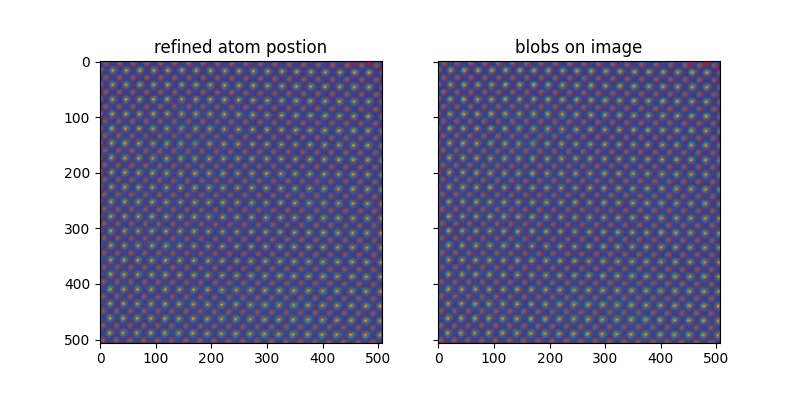

In [15]:
# ------- Input ------
atom_radius = 3  # in pixel
# ----------------------
image_choice = file_tools.ChooseDataset(datasets)  
if dataset.data_type.name == 'IMAGE_STACK':
    image = dataset.sum(axis=0)
    image.data_type = 'image'
else:
    image = dataset
    
atoms = datasets['blob_finding']['atoms']
image = image-image.min()
print(image)

#atom_radius = 2
MaxInt = 0
MinInt = 0 
maxDist = 2
sym = pyTEMlib.atom_tools.atom_refine(np.array(image), atoms, atom_radius, max_int = 0, min_int = 0, max_dist = 2)
refined_atoms = np.array(sym['atoms'])

fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax[0].imshow(image.T)
ax[0].scatter(refined_atoms[:,0],refined_atoms[:,1],  s=10, alpha = 0.3, color = 'red')
ax[0].set_title('refined atom postion')
ax[1].imshow(image.T)
ax[1].scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);
ax[1].set_title('blobs on image');


### Log Refined Atom Positions

In [16]:
out_tags = sym.copy()
out_tags['radius'] = atom_radius
out_tags['MaxInt'] = MaxInt
out_tags['MinInt'] = MinInt
out_tags['maxDist'] = maxDist

out_tags['analysis'] = 'Atom Position Refinement'
out_tags['notebook'] = __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['input'] = image.title
out_tags['input_log'] = dataset.title

out_tags['name'] = 'Atom Refinement'
out_tags['title'] = out_tags['name']

datasets[out_tags['name']] = out_tags

## Reference Lattice

### Reference Crystal

In [17]:
tags_crystal  = ks.structure_by_name('SrTiO3').copy()


Select image for Fourier Transform, this is normally the non-rigid registered stack

In [18]:
image_choice = file_tools.ChooseDataset(datasets)  

Dropdown(description='select dataset:', options=('Channel_000: Recording of SuperScan (HAADF)', 'LR_deconvolut…

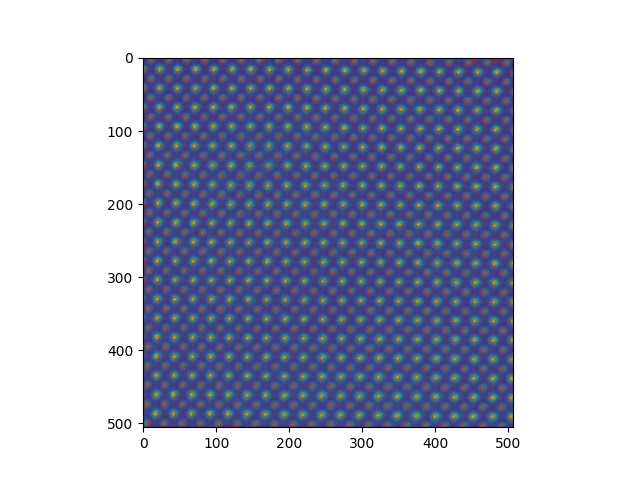

In [19]:
if dataset.data_type.name == 'IMAGE_STACK':
    image = dataset.sum(axis=0)
    image.data_type = 'image'
else:
    image = dataset

atoms = np.array(datasets['Atom Refinement']['atoms'])
image = image-image.min()
image.structures['SrTiO3'] = tags_crystal
plt.figure()
plt.imshow(image.T)
plt.scatter(atoms[:, 0], atoms[:, 1], c='r', s=10, alpha = .3);

### Fourier Transform of Image and Spot Detection

Found 65 reflections


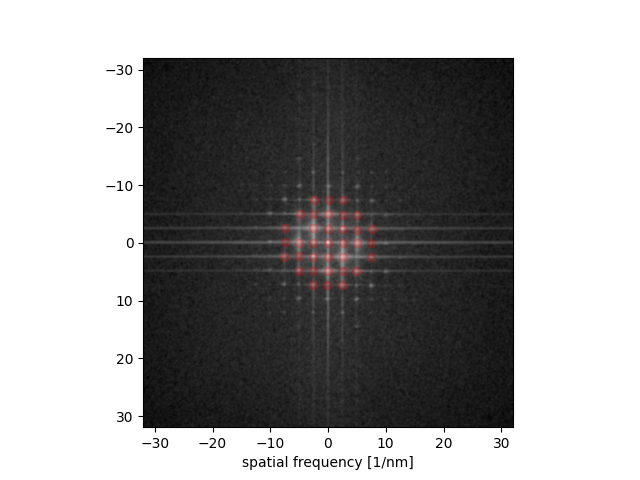

In [20]:
## threshold of Bragg Spot Diffraction (used in it.find_Bragg)
## choose to have a more or less symmetric and same distance of highest order spots
Bragg_threshold = 0.1
fft_image = image_tools.power_spectrum(image, smoothing=1)

spots = image_tools.diffractogram_spots(fft_image, Bragg_threshold)#, verbose = True)
spots = spots[np.linalg.norm(spots[:,:2],axis=1)<8.2]
#print(fft_tags['spots'])
extent = fft_image.get_extent([0,1])
fig = plt.figure()
plt.imshow(fft_image.T, extent=extent, cmap='gray', origin = 'upper')
plt.xlabel('spatial frequency [1/nm]');
plt.scatter(spots[:,0], spots[:,1], c='red',  alpha = 0.2, label='spots');

In [21]:
dist_crystal = np.linalg.norm(spots_crystal, axis = 1)
dist_fft = np.linalg.norm(spots[:,0:2], axis = 1)
number_of_spots = min(len(dist_crystal), len(dist_fft))
dist_crystal, dist_fft

NameError: name 'spots_crystal' is not defined

In [22]:
import scipy.optimize as optimization
def calibrate_image_scale(i, spots_reference, spots_experiment):
    """depreciated get change of scale from comparison of spots to Bragg angles """
    gx =scale_x = file_tools.get_slope(image.x)
    gy = scale_x = file_tools.get_slope(image.y)

    dist_reference = np.linalg.norm(spots_reference, axis=1)
    distance_experiment = np.linalg.norm(spots_experiment, axis=1)

    first_reflections = abs(distance_experiment - dist_reference.min()) < 4
    print('Evaluate ', first_reflections.sum(), 'reflections')
    
    closest_exp_reflections = spots_experiment[first_reflections]

    def func(params, xdata, ydata):
        dgx, dgy = params
        return np.sqrt((xdata * dgx) ** 2 + (ydata * dgy) ** 2) - dist_reference.min()

    x0 = [1.001, 0.999]
    [dg, sig] = optimization.leastsq(func, x0, args=(closest_exp_reflections[:, 0], closest_exp_reflections[:, 1]))
    return dg

In [23]:
dg = calibrate_image_scale(image, spots_crystal, fft_spots[:,:2])
dg

NameError: name 'spots_crystal' is not defined

In [31]:
dist_fft/dist_crystal, dist_fft, dist_crystal

(array([0.93849919, 0.93849919, 0.98594537, 0.98594537, 1.36120131,
        1.36120131, 1.3957158 , 1.3957158 , 1.92639307, 1.92639307,
        1.97189075, 1.97189075, 1.49920165, 1.49920165, 1.52951952,
        1.52951952, 1.5302089 , 1.5302089 , 1.92449421, 1.92449421,
        1.92502935, 1.92502935, 2.02608463, 2.02608463, 1.45447912,
        1.45447912, 1.50705983, 1.50705983, 1.51490065, 1.51490065,
        1.5358656 , 1.5358656 , 1.55157784, 1.55157784]),
 array([2.40316206, 2.40316206, 2.52465483, 2.52465483, 3.48555159,
        3.48555159, 3.57393091, 3.57393091, 4.93280632, 4.93280632,
        5.04930966, 5.04930966, 5.42905457, 5.42905457, 5.53884457,
        5.53884457, 5.54134102, 5.54134102, 6.96916527, 6.96916527,
        6.97110318, 6.97110318, 7.33705437, 7.33705437, 7.44880568,
        7.44880568, 7.71808659, 7.71808659, 7.75824169, 7.75824169,
        7.86560922, 7.86560922, 7.94607614, 7.94607614]),
 array([2.56064373, 2.56064373, 2.56064373, 2.56064373, 2.56064373,


change of scale: 1.530 width a standard deviation of 0.306
rotation angle = 44.03 


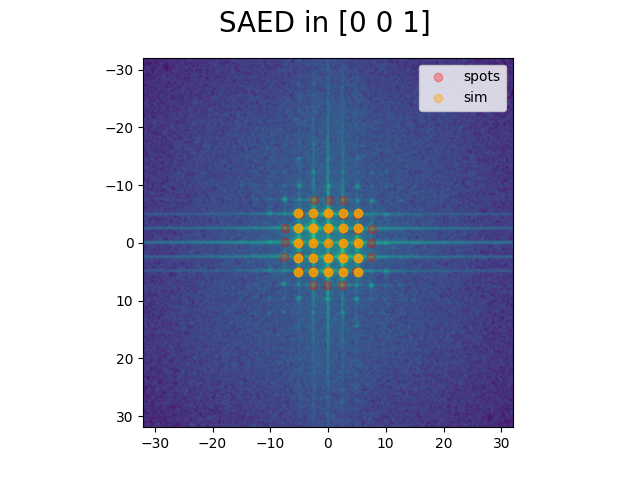

In [29]:
extent = image.get_extent([0,1])
### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 80000#tags['acceleration_voltage'] #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] =  extent[0]
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array([0,0,1])  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .3 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices
tags_experiment['zone_axis'] =  tags_experiment['zone_hkl']


###############################################
# Diffraction Simulation of crystal structure #
###############################################
crystal = image.structures['SrTiO3']

crystal.info['experimental'] = tags_experiment
image.structures['SrTiO3'] = crystal 
ks.kinematic_scattering(crystal, False)

spots_crystal = crystal.info['diffraction']['allowed']['g'][:,0:2]*10

dist_crystal = np.linalg.norm(spots_crystal, axis = 1)
dist_crystal = dist_crystal[dist_crystal > 0]
dist_fft = np.linalg.norm(spots[:,0:2], axis = 1)
number_of_spots = min(len(dist_crystal), len(dist_fft))

dist_crystal = np.sort(dist_crystal)[0:number_of_spots-1]

dist_fft = np.sort(dist_fft)[1:number_of_spots]

change_of_scale = np.median(dist_fft/dist_crystal)
crystal.info['experimental'] ['change_of_scale']= change_of_scale

print(f'change of scale: {change_of_scale:.3f} width a standard deviation of',
      f'{np.std(dist_fft/dist_crystal):.3f}')

fft_spots = spots

rotation_matrix, angle  = image_tools.get_rotation(fft_spots*change_of_scale, spots_crystal)

#rotation_matrix = np.identity(2)
crystal.info['experimental'] ['angle'] = angle
crystal.info['experimental'] ['rotation_matrix']= rotation_matrix

print(f'rotation angle = {np.degrees(angle):.2f} ')
reference_spots = crystal.info['diffraction']['allowed']['g'][:,0:2]*10 # np.dot( crystal.info['diffraction']['allowed']['g'][:,0:2]*10, rotation_matrix)

fig = plt.figure()
fig.suptitle(' SAED in ' + str(crystal.info['experimental']['zone_axis']), fontsize=20)     
extent = fft_image.get_extent([0,1])
plt.imshow(np.log2(1+np.abs(fft_image).T), extent=extent, origin = 'upper')

plt.scatter(spots[:,0], spots[:,1], c='red',  alpha = 0.3, label='spots');


plt.scatter(reference_spots[:,0],reference_spots[:,1], c='orange',  alpha = 0.4 ,label='sim') #atoms.info['crystal_name'].decode('utf-8'))

plt.legend(loc=1);


### Starting Point

Make sure the starting point orange is on the main sublattice

You can select with the starting atom with the mouse in the image below

In [71]:
#### Get atoms in units of nm
image_channel = image_choice.image_channel
image_log = image_choice.log_key
current_dataset = image_channel['nDim_Data']

if current_dataset.attrs['data_type'] == 'image_stack':
    image = np.sum(current_dataset, axis=0)
else:
    image = np.array(current_dataset)

for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])
extent = it.make_extent(image.shape, scaleX,scaleY)
atoms = atom_channel['atoms'][()]*(scaleX,scaleY)

##### select starting atom, 
# will be orange in image below, make usre it is in right sublattice
selected_atom_index  = np.argmin(np.linalg.norm(atoms-[extent[1]/2,extent[2]/2], axis= 1))
startx,starty = atoms[selected_atom_index]

fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(image.T, extent=extent)
plt.scatter(startx ,starty, color='orange')
def onclick(event):
    global start_atom_x, start_atom_y
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    ax.clear()
    ax.imshow(image.T, extent=extent)
    plt.scatter(event.xdata,event.ydata, color='orange')
    
    start_atom_x = event.xdata
    start_atom_y = event.ydata
    
cid = fig.canvas.mpl_connect('button_press_event', onclick)

AttributeError: 'ChooseDataset' object has no attribute 'image_channel'

In [ ]:
for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])
extent = it.make_extent(image.shape, scaleX,scaleY)
atoms = atom_channel['atoms'][()]*(scaleX,scaleY)

##### select starting atom, 
selected_atom_index  = np.argmin(np.linalg.norm(atoms-[start_atom_x,start_atom_y], axis= 1))
print(selected_atom_index, atoms[selected_atom_index])
plt.figure()

plt.imshow(image.T, extent=extent)
plt.scatter(atoms[selected_atom_index][0] ,atoms[selected_atom_index][1], color='orange')


### Walk Through Lattice

Walk through the refined atom positions to determine the regular lattice.

First we determine the  projection of the unit cell with the lattice vectors, which are use to walk through the collection of atom positions.

The breadth first approach is used to hit all refined atom positions and correlate them with the ideal lattice.
Any sublattice can then be deduced from the shift of the base in relative coordinates.


We rotate the structure so that the z-axis is the zone axis. The projection along z-axis is to neglect those z-coordinates.

Then we rotate this projection in-plane according to the Fourier Anlysis to reach coincidence with image.

Horizontal and vertical steps for random walk are defined as largest unit cell vectors in this projection.

The projected element positions define the different sub_lattices if they exist

In [ ]:
#### INPUT ####
# change accuracy to higher value if we do not hit all atoms in Random Walk.
accuracy = 0.04  ## maximum deviation of distance to new atom in walk through atom position 
exclude=['O']  ## excude atom columns which are not visible
zone_axis = [0,0,1]


### Define exxperimental parameters:
tags_experiment= {}
tags_experiment['acceleration_voltage_V'] = 200000#tags['acceleration_voltage'] #V
tags_experiment['new_figure'] = False
tags_experiment['plot FOV'] = fft_tags['extent'][0]
tags_experiment['convergence_angle_mrad'] = 0
tags_experiment['zone_hkl'] = np.array(zone_axis)  # incident neares zone axis: defines Laue Zones!!!!
tags_experiment['mistilt']  = np.array([0,0,0])  # mistilt in degrees
tags_experiment['Sg_max'] = .2 # 1/nm  maximum allowed excitation error ; This parameter is related to the thickness
tags_experiment['hkl_max'] = 2  # Highest evaluated Miller indices
tags_experiment['zone_axis'] =  tags_experiment['zone_hkl']

current_channel = h5_file['Measurement_000/Channel_000']

for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])
extent = it.make_extent(image.shape, scaleX,scaleY)
atoms = atom_channel['atoms'][()]*(scaleX,scaleY)

##### select starting atom, 
selected_atom_index  = np.argmin(np.linalg.norm(atoms-[start_atom_x,start_atom_y], axis= 1))
print(selected_atom_index, atoms[selected_atom_index])



###############################################
# Diffraction Simulation of crystal structure #
###############################################
tags_crystal = ft.h5_get_crystal_structure(structure_group)

tags_crystal.update(tags_experiment)

ks.Kinematic_Scattering(tags_crystal, False)

spots_crystal = tags_crystal['allowed']['g'][:,0:2]
dist_crystal = np.linalg.norm(spots_crystal, axis = 1)
dist_fft = np.linalg.norm(fft_tags['spots'][:,0:2], axis = 1)
number_of_spots = min(len(dist_crystal), len(dist_fft))

dist_crystal = np.sort(dist_crystal)[0:number_of_spots-1]
dist_fft = np.sort(dist_fft)[1:number_of_spots]

change_of_scale = np.median(dist_fft/dist_crystal)
tags_crystal['change_of_scale']= change_of_scale

for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])*change_of_scale
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])*change_of_scale
extent = it.make_extent(image.shape, scaleX,scaleY)
atoms = atom_channel['atoms'][()]*(scaleX,scaleY) ## new scale
print(change_of_scale)


fft_spots = fft_tags['spots']

rotation_matrix, angle  = ait.get_rotation(fft_tags['spots']*change_of_scale, spots_crystal)

tags_crystal['angle']= angle
tags_crystal['rotation_matrix']= rotation_matrix

print(f'rotation angle = {np.degrees(angle):.2f} ')
reference_spots = np.dot(tags_crystal['allowed']['g'][:,0:2], rotation_matrix)

## Rotate in plane to match image
rotation_matrix_fft=np.identity(3)
rotation_matrix_fft[0:2,0:2] = rotation_matrix

### 
change_of_scale2 = 1.0 
projection_tags = ait.get_projection(structure_group,zone_axis, rotation_matrix_fft, change_of_scale2)

projected_positions = []
for i in range(1,len(projection_tags['projected_elements'])):
    if projection_tags['projected_elements'][i] not in exclude:
        projected_positions.append(projection_tags['projected_positions'][i])

points = projection_tags['points'][:,:2]
points = np.append(points,points+projection_tags['left'],axis = 0)
points = np.append(points,points+2*projection_tags['left'],axis = 0)
points = np.append(points,points-2*projection_tags['left'],axis = 0)
points = np.append(points,points+projection_tags['up'],axis = 0)
points = np.append(points,points+2*projection_tags['up'],axis = 0)
points = np.append(points,points-2*projection_tags['up'],axis = 0)
points = np.unique(np.round(points,5),axis = 0)

projected_positions = np.append(projected_positions,projected_positions+projection_tags['left'],axis = 0)
projected_positions = np.append(projected_positions,projected_positions+2*projection_tags['left'],axis = 0)
projected_positions = np.append(projected_positions,projected_positions-2*projection_tags['left'],axis = 0)
projected_positions = np.append(projected_positions,projected_positions+projection_tags['up'],axis = 0)
projected_positions = np.append(projected_positions,projected_positions+2*projection_tags['up'],axis = 0)
projected_positions = np.append(projected_positions,projected_positions-2*projection_tags['up'],axis = 0)
projected_positions = np.unique(np.round(projected_positions,5),axis = 0)

max_radius = np.max(np.linalg.norm([projection_tags['up'],projection_tags['left']],axis=1))

near_points = points[np.linalg.norm(points, axis=1)<max_radius*1.01]
near_points = near_points[np.linalg.norm(near_points, axis=1)>1e-3]
near_points2 = projected_positions[np.linalg.norm(projected_positions, axis=1)<max_radius*1.01]

distances_unit_cell = np.unique(np.round(np.linalg.norm(near_points,  axis=1),4))
distances_base      = np.unique(np.round(np.linalg.norm(near_points2, axis=1),4))

print(f'We will evaluate {near_points.shape[0] +near_points2.shape[0]} next nearest neighbours')
max_radius = np.max(np.linalg.norm([projection_tags['up'],projection_tags['left']],axis=1))

near_main = points[np.linalg.norm(points, axis=1)<max_radius*1.01]
near_main = near_points[np.linalg.norm(near_points, axis=1)>1e-3]
near_base = projected_positions[np.linalg.norm(projected_positions, axis=1)<max_radius*1.01]

distances_unit_cell = np.unique(np.round(np.linalg.norm(near_main,  axis=1),2))
distances_base      = np.unique(np.round(np.linalg.norm(near_base, axis=1),2))

up = projection_tags['up']
left = projection_tags['left']

projection_tags['distance_unit_cell'] =  np.max(distances_unit_cell)*1.0+accuracy
projection_tags['allowed_variation'] = accuracy
projection_tags['number_of_neares_neighbours'] = near_main.shape[0] +near_base.shape[0]

projection_tags['near_base'] = near_base

atoms_hopped, atoms_ideal = ait.breadth_first_search(atoms, selected_atom_index, projection_tags)

plt.figure()
plt.imshow(image.T, extent=extent)
atoms_hopped =  np.array(atoms_hopped)
plt.scatter(atoms_hopped[:,0],atoms_hopped[:,1], color ='red')

atoms_ideal =  np.array(atoms_ideal)
plt.scatter(atoms_ideal[:,0],atoms_ideal[:,1], color ='cyan')
#plt.scatter(startx,starty, color ='orange');
plt.scatter(atoms[selected_atom_index][0] ,atoms[selected_atom_index][1], color='orange')


# store main sublattice in dictionary
sub_lattice = {}
sub_lattice[0] = {}
sub_lattice[0]['shift'] = [0.0, 0.0]
sub_lattice[0]['atoms'] = np.array(atoms_hopped)
sub_lattice[0]['ideal_lattice'] = np.array(atoms_ideal)
sub_lattice[0]['element'] = projection_tags['projected_elements'][0]

### Get Other sublattices
At this point you will have to define the shift and the element for each sublattice in the dictionary.

In [ ]:
# Define other sublattices
    
print('Sublattice options: ',projection_tags['projected_elements'])
sub_lattice[1] = {}
sub_lattice[1]['element'] = 'Ti+O'

for i, element in enumerate(projection_tags['projected_elements']):
    if element == sub_lattice[1]['element']:
        sub_lattice[1]['shift'] = projection_tags['projected_positions'][i]-projection_tags['projected_positions'][0]
print(sub_lattice[1])

For each selected sublattice, we shift the unit cell (origin) lattice by the base vector of the 
the elements.

We determine the nearest (refined) atom position for each shifted lattice point and update this atom position.

The ideal lattice of the selected sublatice is just the shifted ideal lattice. 

In [ ]:
from scipy.spatial import Voronoi, KDTree, cKDTree

change_of_scale = tags_crystal['change_of_scale']

for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])*change_of_scale
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])*change_of_scale
extent = it.make_extent(image.shape, scaleX,scaleY)
atoms = atom_channel['atoms'][()]*(scaleX,scaleY)


atoms = atom_channel['atoms'][()]*(scaleX,scaleY)  ## new scale !!!
neighbourtree = cKDTree(atoms)
        
for key in sub_lattice:
    if key > 0:
        shifted_lattice = sub_lattice[0]['atoms']+sub_lattice[key]['shift']# np.dot(sub_lattice[key]['shift'],rotated_cell)
        distances, indices = neighbourtree.query(np.array(shifted_lattice), 1)
        
        sub_lattice[key]['atoms'] = atoms[indices[np.where(distances <0.05)]]
        sub_lattice[key]['ideal_lattice'] = np.array(sub_lattice[0]['ideal_lattice'])[np.where(distances <0.05)] + sub_lattice[key]['shift']# Define other sublattices

## Plot sublattices
plt.figure()
plt.imshow(image.T, extent=extent)
colors = ['red', 'orange', 'cyan', 'blue', 'green','green']
plt.scatter(sub_lattice[1]['atoms'] [:,0], sub_lattice[key]['atoms'][:,1], color = colors[i], alpha = 0.6, label='atoms')
for i, key in enumerate (sub_lattice):
    
    plt.scatter(sub_lattice[key]['ideal_lattice'] [:,0], sub_lattice[key]['ideal_lattice'][:,1], color = colors[i+2], alpha = 0.6, label='ideal '+sub_lattice[key]['element'])
    pass
plt.legend(loc="upper right");
key = 1
#plt.scatter(sub_lattice[key]['ideal_lattice'] [:,0], sub_lattice[key]['ideal_lattice'][:,1], color = colors[i+2], alpha = 0.6)
#print(sub_lattice[key]['ideal_lattice'])
#print(sub_lattice[key]['shift'])
        
        

### Log Random Walk Analysis

In [ ]:
for dim in current_dataset.dims:
    if dim.label == 'x': scaleX = (dim[0][1]-dim[0][0])*change_of_scale
    if dim.label == 'y': scaleY = (dim[0][1]-dim[0][0])*change_of_scale


diffraction_channel = ft.h5_add_diffraction(current_channel, tags_crystal)


out_tags = {}

out_tags['analysis']= 'Atom Classification'
out_tags['input'] = image_channel['analysis'][()]
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['accuracy'] = accuracy
out_tags['step_up'] = up
out_tags['step_left'] = left
out_tags['step_size'] = projection_tags['r']
out_tags['start_atom'] = [startx,starty]

out_tags['sub_lattices'] = []
for key in sub_lattice:
    out_tags['sub_lattices'].append(key)
    out_tags['sub_lattice_'+str(key)+'_atoms'] = sub_lattice[key]['atoms']
    out_tags['sub_lattice_'+str(key)+'_ideal_lattice'] = sub_lattice[key]['ideal_lattice']
    out_tags['sub_lattice_'+str(key)+'_shift'] = sub_lattice[key]['shift']
    out_tags['sub_lattice_'+str(key)+'_element'] = sub_lattice[key]['element']
    
    if 'intensities' in sub_lattice[key]:
        out_tags['sub_lattice_'+str(key)+'_intensities'] = sub_lattice[key]['intensities']
        
    if 'histo_intensity' in sub_lattice[key]:
        out_tags['sub_lattice_'+str(key)+'_histo_intensity'] = sub_lattice[key]['histo_intensity']   
    if 'histo_mulitplicity' in sub_lattice[key]:
        out_tags['sub_lattice_'+str(key)+'_histo_mulitplicity'] = sub_lattice[key]['histo_mulitplicity']      

for key in projection_tags:
    if key not in  ['projected_elements']:
        out_tags['projection_'+key] = projection_tags[key]
    else:
        elem_string = ''
        for elem in projection_tags['projected_elements']:
            elem_string = elem_string+elem+'_'
        out_tags['projection_'+key] = elem_string[:-1]
        
out_tags['scale_x'] = scaleX
out_tags['scale_y'] = scaleY
if abs(scaleX-scaleY)>0.001 :
    print('problem: scale of x and y different')
out_tags['image_extent'] = extent

out_tags['name'] = 'Atom Classification'
out_tags['title'] = out_tags['name']

walk_channel = ft.log_results(current_channel, out_tags)

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")


## Distortion Matrix
The distortion matrix is defined on the pixel grid of the image, so the atoms have to be transformed back to that.

The distortion matrix contains in each pixel where the pixel has to be moved (x,y are real not integers).



In [ ]:

#### Get atoms in units of nm
image_channel = image_choice.image_channel
image_log = image_choice.log_key
current_dataset = image_channel['nDim_Data']

if current_dataset.attrs['data_type'] == 'image_stack':
    image = np.sum(current_dataset, axis=0)
else:
    image = np.array(current_dataset)

scale_x = walk_channel['scale_x'][()]
scale_y = walk_channel['scale_y'][()]

for key in walk_channel['sub_lattices']:
    if key ==0:
        ideal_lattice1 = walk_channel['sub_lattice_'+str(key)+'_ideal_lattice'][()]/ [scale_x,scale_y]
        atoms1 = walk_channel['sub_lattice_'+str(key)+'_atoms'][()]/ [scale_x,scale_y]
        
    else:
        
        ideal_lattice_to_add = walk_channel['sub_lattice_'+str(key)+'_ideal_lattice'][()]/ [scale_x,scale_y]
        atoms_to_add = walk_channel['sub_lattice_'+str(key)+'_atoms'][()]/ [scale_x,scale_y]
        
        ideal_lattice = np.concatenate((ideal_lattice1, ideal_lattice_to_add), axis=0)
        atoms = np.concatenate((atoms1, atoms_to_add), axis=0)

distortion_matrix = it.get_distortion_matrix(atoms,ideal_lattice)

## delete too large voronoi cells
distortion_matrix = distortion_matrix[np.where(distortion_matrix[:,0]<image.shape[0])]
distortion_matrix = distortion_matrix[np.where(distortion_matrix[:,1]<image.shape[1])]
distortion_matrix = distortion_matrix[np.where(distortion_matrix[:,0]>0)]
distortion_matrix = distortion_matrix[np.where(distortion_matrix[:,1]>0)]

## Visualize Distortion Matrix ( check whether you got all pixels)
dist_image = np.zeros(image.shape)
difference = distortion_matrix[:,:2]-distortion_matrix[:,2:]

distance_image = np.zeros(image.shape)
angle_image = np.zeros(image.shape)

distance_image[(distortion_matrix[:,0].astype(int),distortion_matrix[:,1].astype(int))] = np.linalg.norm(difference, axis =1)
angle_image[(distortion_matrix[:,0].astype(int),distortion_matrix[:,1].astype(int))] = np.degrees(np.arctan2(difference[:,1],difference[:,0]))
             
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
fig.suptitle('Distortion Matrix in Polar Coordinates')

ax[0].set_title('norm')
norm_fig = ax[0].imshow(distance_image*scaleX*1000)
fig.colorbar(norm_fig, ax=ax[0] , label = 'distance [pm]')

ax[1].set_title('angle')
angle_fig = ax[1].imshow(angle_image,cmap = 'twilight')
fig.colorbar(angle_fig, ax=ax[1], label = 'angle [$^o$]');

### Log Distortion Matrix

In [ ]:
out_tags = {}

out_tags['analysis']= 'Distortion Matrix'
out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__
out_tags['input']= image_channel['analysis'][()]
out_tags['input_log'] = image_channel.name.split('/')[-1]


out_tags['distortion_matrix'] = distortion_matrix
out_tags['ideal_lattice'] = ideal_lattice
out_tags['atoms'] = atoms


out_tags['scale_x'] = walk_channel['scale_x'][()]
out_tags['scale_y'] = walk_channel['scale_y'][()]

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            if  current_channel[key]['analysis'][()] == 'Rigid Registration':
                out_tags['distortion_crop'] = current_channel[key]['Rigid_registration_crop'][()]
            

out_tags['name'] = 'Distortion_Matrix'
out_tags['title'] = out_tags['name']

distortion_channel = ft.log_results(current_channel, out_tags)

for key in current_channel:
    if 'Log' in key:
        if 'analysis' in current_channel[key]:
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

h5_file.flush()

## Undistort image data
As a test we undistort image data

Everything, we need to undistort an image is stored in the distortion_channel of the h5_file.

In [ ]:
print(distortion_channel)
distortion_matrix = distortion_channel['distortion_matrix'][()]
ideal_lattice = distortion_channel['ideal_lattice'][()]
choice = ait.choose_image(current_channel)  


In [ ]:
image_channel = image_choice.image_channel
image_log = image_choice.log_key
current_dataset = image_channel['nDim_Data']

if current_dataset.attrs['data_type'] == 'image_stack':
    image = np.sum(current_dataset, axis=0)
else:
    image = np.array(current_dataset)

print(distortion_channel.name)

# get input
distortion_matrix = distortion_channel['distortion_matrix'][()]
ideal_lattice = distortion_channel['ideal_lattice'][()]

# undistort
interpolated = it.undistort(distortion_matrix, image)

## get image scale
scaleX = distortion_channel['scale_x'][()]
scaleY = distortion_channel['scale_y'][()]
extent = it.make_extent(interpolated.shape, scaleX,scaleY)

#plot
plt.figure()
plt.imshow(interpolated.T, extent = extent)
plt.scatter(ideal_lattice[:,0]* scaleX ,ideal_lattice[:,1]*scaleY, s=4, color='orange');

### Log Undistorted Image

You may want to save this image to analyse the precision reached.

In [ ]:

out_tags = {}
out_tags['analysis']= 'Undistorted Image'
name = 'undistorted_image'

out_tags['notebook']= __notebook__ 
out_tags['notebook_version']= __notebook_version__

out_tags['input']= image_channel['analysis'][()]
out_tags['input_log'] = image_log
out_tags['data'] = interpolated
out_tags['data_type'] = 'image'
out_tags['spatial_origin_x'] = 0
out_tags['spatial_origin_y'] = 0
out_tags['spatial_scale_x'] = scaleX
out_tags['spatial_scale_y'] = scaleY
out_tags['spatial_size_x'] = interpolated.shape[0]
out_tags['spatial_size_y'] = interpolated.shape[1]
out_tags['spatial_units'] = 'nm'
out_tags['FOV_x'] = out_tags['spatial_scale_x']* interpolated.shape[1]
out_tags['FOV_y'] = out_tags['spatial_scale_y']* interpolated.shape[0]
out_tags['extent'] = it.make_extent(interpolated.shape, scaleX,scaleY)

out_tags['dim_dict'] = {0: ft.Dimension('x', 'distance', 'nm', (np.arange(interpolated.shape[0])-0.5)*scaleX, True),
                        1: ft.Dimension('y', 'distance', 'nm', (np.arange(interpolated.shape[1])-0.5)*scaleY, True),
                        }


out_tags['name'] = 'undistorted_image'
out_tags['title'] = out_tags['name']

image_channel = ft.log_results(current_channel, out_tags)

h5_file.flush()
for key in current_channel:
    if 'Log' in key:
        if 'analysis' in dict(current_channel[key]).keys():
            print(f"{key} includes analysis: {current_channel[key]['analysis'][()]}")

## Close File

In [ ]:
h5_file.close()

Now that a distortion matrix is determined, we can go head and remove distortions from an image or stack in the 
[Undistorted Registration](4_undistorted_registration.ipynb) notebook

## Appendix

### Code for distortion_matrix 

The distortion matrix determines where each pixel has to move by
- first, undistort Vornoi tile
- second, move this tile to correct position so that center atom coincides with ideal lattice

This code depends on the `` Voronoi`` algorithm as implemented by [scipy.spatial](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.Voronoi.html)

and

on two helpwer functions, which are explained below

In [ ]:
from scipy.spatial import Voronoi
def get_distortion_matrix(atoms,ideal_lattice, image.shape):
    """
    Calculates 
    """
    vor = Voronoi(atoms)

    #determine a middle Voronoi tile
    ideal_vor = Voronoi(ideal_lattice)
    index = np.argmin(np.linalg.norm(ideal_lattice-np.array(image.shape)/2,axis=0)) 

    ## the ideal vertices fo such an vornoi tile (are there crystals with more than one voroni?)
    ideal_vertices = ideal_vor.vertices[ideal_vor.regions[ideal_vor.point_region[index]]]
    ideal_vertices = get_significant_vertices(ideal_vertices - np.average(ideal_vertices,axis=0))
        
    distortion_matrix=[]
    for index in range(vor.points.shape[0]):
        done = int((index+1)/vor.points.shape[0]*50)
        sys.stdout.write('\r')
        # progress output :
        sys.stdout.write("[%-50s] %d%%" % ('='*done, 2*done))
        sys.stdout.flush()

        ## determine vertices of Voronoi polygons of an atom with number index 
        poly_point = vor.points[index]  
        poly_vertices = get_significant_vertices(vor.vertices[vor.regions[vor.point_region[index]]]-poly_point)

        # where ATOM has to be moved (not pixel)
        ideal_point = ideal_lattice[index]
        
        # transform voronoi to ideal one and keep transformation matrix A
        uncorrected, corrected, A = transform_vornoi(poly_vertices,ideal_vertices)
        
        # pixel positions 
        corrected = corrected+ideal_point+(np.rint(poly_point)-poly_point) 
        for i in range(len(corrected)):
            # original image pixels
            x,y = uncorrected[i]+[int(poly_point[0]+0.5),int(poly_point[1]+0.5)]
            # collect the two origin and target coordinates and store
            distortion_matrix.append([x,y,corrected[i,0],corrected[i,1]] )
    print()
    return np.array(distortion_matrix)


The helper functions to determine the distortion matrix

``get_significant_vertices`` checks the nearest neighbour distances between vertices, and returns the average if too close, and original vertic if not

``tranform vornoi`` determins the tranformation matrix between voronoi and ideal shape and then returns the coordinates to which the pixels inside voronoi cell are to be moved.

In [ ]:
from scipy.spatial import Voronoi, cKDTree
from skimage.measure import points_in_poly
import sys


def get_significant_vertices(vertices, distance = 3):
    """
        calculate average for  all points that are closer than distance appart,
        otherwise leave the points alone
        
        input: 
        vertices: list of points
        distance: float (in same scale as points )
        
        returns 
        list of points that are all a minimum of 3 appart.
    """
    T = cKDTree(np.array(vertices))
    near = T.query_ball_point(vertices, distance)
    ideal_vertices = []
    for indices in near:
        if len(indices) == 1:
            ideal_vertices.append(vertices[indices][0])
        else:
            ideal_vertices.append(np.average(vertices[indices],axis=0))
    ideal_vertices = np.unique(np.array(ideal_vertices),axis=0) 
    angles = np.arctan2(ideal_vertices[:,1],ideal_vertices[:,0])
    ang_sort = np.argsort(angles)
    #print(ang_sort)
    ideal_vertices= ideal_vertices[ang_sort]
            
    return ideal_vertices



def transform_vornoi(vertices, ideal_voronoi ):
    """
    find transfomration matrix A between a polygone and a perfect one
    
    returns:
    list of points: all points on a grid within original polygone
    list of points: coordinates of these points where pixel have to move to
    2x2 matrix A:  transformation matrix
    """
    ## Find Transformation Matrix, note polygons have to be ordered first.
    sort_vert = []
    for vert in ideal_voronoi:
        sort_vert.append(np.argmin(np.linalg.norm(vertices-vert,axis=1)))
    vertices = np.array(vertices)[sort_vert]

    # Solve the least squares problem X * A = Y
    # to find our transformation matrix A
    A, res, rank, s = np.linalg.lstsq(vertices, ideal_voronoi, rcond=None)

    # expand polygone to include more points in distortion matrix 
    vertices2 = vertices+np.sign(vertices)#+np.sign(vertices)
    
    extV = int(np.abs(vertices2).max()+1)

    polygone_grid = np.mgrid[0:extV*2+1,:extV*2+1]-extV
    polygone_grid = np.swapaxes(polygone_grid,0,2)
    polygone_array = polygone_grid.reshape(-1, polygone_grid.shape[-1])
    
    p = points_in_poly(polygone_array, vertices2)
    uncorrected = polygone_array[p]
        
    corrected = np.dot(uncorrected,A)
    #print(sum(p))
    
    #print(np.array(uncorrected).shape,np.array(corrected).shape)
    
    return uncorrected, corrected, A


### Undistort single cell

A distortion matrix stores where each pixel is supposed to move. 

The image is sectioned with Vornoi tiling with an atom at the center of each Voronoi cell.

We use a random cell to show distortions and how to remove these distortions.


In [ ]:
from scipy.interpolate import  griddata

vor = Voronoi(atoms)
    
ideal_vor = Voronoi(ideal_lattice)

index = np.argmin(np.linalg.norm(ideal_lattice-np.array(image.shape)/2,axis=0)) 

ideal_vertices = ideal_vor.vertices[ideal_vor.regions[ideal_vor.point_region[index]]]
ideal_vertices = get_significant_vertices(ideal_vertices - np.average(ideal_vertices,axis=0))


#for index in range(vor.points.shape[0]):
#    done = int((index+1)/vor.points.shape[0]*50)
#    sys.stdout.write('\r')
#    # progress output :
#    sys.stdout.write("[%-50s] %d%%" % ('='*done, 2*done))
#    sys.stdout.flush()

    ## determine vertices of Voronoi polygons of an atom with number index 
index = 455
poly_vertices = get_significant_vertices(vor.vertices[vor.regions[vor.point_region[index]]]-vor.points[index] )

poly_point = vor.points[index]  

tags2 ={}    
tags2['significant_vertices']= poly_vertices
tags2['atom']=[0,0]
uncorrected, corrected, A = transform_vornoi(poly_vertices,ideal_vertices)
print(uncorrected.shape,corrected.shape)
trans_vert = np.dot(poly_vertices,A)

    
extV = int(np.abs(poly_vertices).max()+3)

sizex = int(extV*2+1)
sizey = int(extV*2+1)
grid_x, grid_y = np.mgrid[0:sizex-1:sizex*1j, 0:sizey-1:sizey*1j]
print('interpolate')
area = np.zeros((sizex,sizey))


# Serialize image data
intensity_values =[]
for i in range(len(corrected)):
    x,y = uncorrected[i]+[int(poly_point[0]+0.5),int(poly_point[1]+0.5)]
    intensity_values.append(image[x,y])
    
    ##for visualization only
    xi,yi = uncorrected[i]+[int(extV),int(extV)]
    area[xi,yi]=image[x,y]

    
interpolated = griddata(np.array(corrected+[extV,extV]), intensity_values, (grid_x, grid_y), method='linear')


fig = plt.figure()
ax = fig.add_subplot(121)
ax.set_title('original image')
ax.imshow(area.T,extent=[-extV-0.5,extV+0.5,extV+0.5,-extV-0.5])

poly = patches.Polygon(ideal_vertices, closed=True,fill=False, edgecolor = 'black',linewidth = .5)
ax.add_patch(poly)
poly = patches.Polygon(poly_vertices, closed=True,fill=False, edgecolor = 'black',linewidth = .5)
ax.add_patch(poly)


ax.scatter(ideal_vertices[:,0],ideal_vertices[:,1], label='ideal')
ax.scatter((poly_vertices)[:,0],(poly_vertices)[:,1],color='red', label='original')
ax.scatter(trans_vertices[:,0],trans_vertices[:,1],color='orange', label='undistorted ')

ax.set_aspect('equal')
#ax.legend()
ax.legend(loc="upper left", bbox_to_anchor=(0.6,0.5))

ax2 = fig.add_subplot(122)
ax2.set_title('undistorted image')
ax2.imshow(interpolated.T,extent=[-extV-0.5,extV+0.5,extV+0.5,-extV-0.5])

poly = patches.Polygon(ideal_vertices, closed=True,fill=False, edgecolor = 'black',linewidth = .5)
ax2.add_patch(poly)
ax2.scatter(trans_vertices[:,0],trans_vertices[:,1],color='orange')
ax2.set_aspect('equal')


### Code for Undistortion

uses ``griddata`` interpolation method of scipy.

In [ ]:
from scipy.interpolate import  griddata

def undistort(distortion_matrix, image):
    """
    use the griddata interpolation of scipy to apply distortion matrix to image
    The distortion matrix contains in origin and target pixel coordinates 
    target is where the pixel has to be moved (floats)
    input:
     - distortion matrix (format N x 2)
     - image
     returns:
     - numpy array of undistorted image
    """        

    intensity_values = image[(distortion_matrix[:,0].astype(int),distortion_matrix[:,1].astype(int))]

    corrected = distortion_matrix[:,2:4]

    sizex,sizey = 2**np.round(np.log2(image.shape[0:2])) ## nearest power of 2
    sizex = int(sizex)
    sizey = int(sizey)
    grid_x, grid_y = np.mgrid[0:sizex-1:sizex*1j, 0:sizey-1:sizey*1j]
    print('interpolate')

    interpolated = griddata(np.array(corrected), np.array(intensity_values), (grid_x, grid_y), method='linear')
    return interpolated



### Code for Unit Cell Projection

We rotate the structure so that the z-axis is the zone axis. The projection along z-axis is to neglect those z-coordinates.

Then we rotate this projection in-plane according to the Fourier Anlysis to reach coincidence with image.

Horizontal and vertical steps for random walk are defined as largest unit cell vectors in this projection.

The projected element positions define the different sub_lattices if they exist

In [ ]:
def get_projection(structure_group,zone_axis, in_plane_rotation_matrix =np.identity(3), change_of_scale = 1.0 ):
    """
    Reads information from structure group a h5py group with keys: 'title', 'elements'(array of bytes), 
    'unit_cell' and 'relative_positions'
    and determines the projected cell along zone_axis.
    the in_plane_rotation_matrix is a 3x3 unit_cell
    
    Specifically this function calculates the projected values of 
    - unit vectors (left, up), 
    - the lines and points to plot projected unit cell, and
    - projected element_positions with added atomic numbers and names. 
    """
    
    projection_tags = {}
    
    projection_tags['zone_axis'] = zone_axis
    projection_tags['structure'] = structure_group['title'][()]
    ### Read information from structure_group
    unit_cell = structure_group['unit_cell'][()]/change_of_scale
    relative_positions = structure_group['relative_positions'][()]
    
    elements =[]
    elements_Z = []
    for name in structure_group['elements'][()]:
        element = name.decode(("utf-8") )
        elements_Z.append(ks.electronFF[element]['Z'])
        elements.append(element)
        
    rotation_matrix ,theta, phi = ks.get_rotation_matrix(np.dot(zone_axis,unit_cell))

    ## use rotation to calculate rotated cell
    rotated_cell = np.dot(rotation_matrix, unit_cell)
    
    rotated_cell = np.dot(rotated_cell,in_plane_rotation_matrix)
    element_position= np.round(np.dot(relative_positions,rotated_cell),3)

    projection_tags['rotated_cell'] = rotated_cell
    
    ### Determine projection of elements

    elementTree = cKDTree(element_position[:,0:2])  
    done = []
    projected_elements=[]
    projected_Z = []
    projected_positions= []
    for i, pos in enumerate(np.array(element_position)[:,0:2]):
        near = elementTree.query_ball_point(pos, 0.05)

        if near[0] not in done:
            done.append(near[0])
            projected_elements.append(elements[near[0]])
            projected_Z.append(elements_Z[near[0]])
            projected_positions.append(element_position[near[0],0:2])
            if len(near)>1:
                for elem in near[1:]:
                    if elem not in done:
                        done.append(elem)
                        projected_elements[i] = projected_elements[i]+'+'+elements[elem]
                        projected_Z[i] = projected_Z[i]+elements_Z[elem]


    projected_positions = np.array(projected_positions)
    
    projection_tags['projected_positions'] = projected_positions
    projection_tags['projected_elements'] = projected_elements
    projection_tags['projected_Z'] = projected_Z
    
    ## We use the two longest axis of the rotated cell as our hopps
    axis_indices_sorted = np.argsort(np.linalg.norm(rotated_cell[:,0:2],axis=1))

    if abs(rotated_cell[axis_indices_sorted[1],0])>abs(rotated_cell[axis_indices_sorted[2],0]):
        left = rotated_cell[axis_indices_sorted[1],0:2]
        up =  rotated_cell[axis_indices_sorted[2],0:2]
    else:
        left = rotated_cell[axis_indices_sorted[2],0:2]
        up = rotated_cell[axis_indices_sorted[1],0:2]

    if left[0]>0:
        left = -left
    if up[1]>0:
        up = -up
    r = np.linalg.norm([up,left],axis=0).max()*1.1
    
    projection_tags['left']= left
    projection_tags['up']= up
    projection_tags['r']= r
    
    
    ## Plot projection 
    points, lines = ait.get_projected_cell(rotated_cell)    

    projection_tags['points']= points
    projection_tags['lines']= lines
    
    return projection_tags
    